In [1]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import Required Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet

In [5]:
# Importing Data
from pandas_datareader.fred import FredReader

In [6]:
fred_data = [ "EXJPUS", # JPY to USD Spot Exchange Rate 
            ]

In [7]:
df = FredReader(symbols=fred_data, start='1997', end=None).read()

In [8]:
df.head(10) # see the first 10 values

,EXJPUS
DATE,
1997-01-01,117.9124
1997-02-01,122.9621
1997-03-01,122.7738
1997-04-01,125.6377
1997-05-01,119.1924
1997-06-01,114.2857
1997-07-01,115.3759
1997-08-01,117.9295
1997-09-01,120.8900


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 1997-01-01 to 2024-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EXJPUS  328 non-null    float64
dtypes: float64(1)
memory usage: 5.1 KB


Date Column is already defined, there is no need to convert it to datetime64 format.

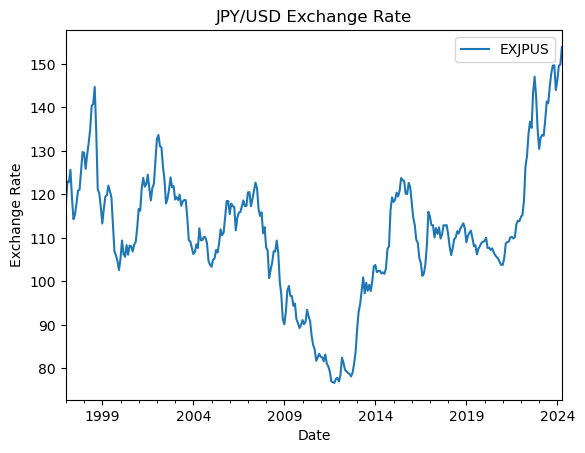

In [10]:
# To better visualize the presence of nonstationarity, we will graph the exchange rate variable.
df.plot(title="JPY/USD Exchange Rate",
        xlabel="Date",
        ylabel="Exchange Rate")

plt.show()

In [11]:
# Before preprocessing the data, we check for stationarity using ADF test.
result = adfuller(df.iloc[:, 0])  # the time series data is in the first column

# Print the ADF test statistic.
print('ADF Statistic:', result[0])
# result[0] corresponds to the ADF test statistic.
# We compare it to the critical values generated below.
# If our test statistic is more negative than the critical values, we reject H0 and thus our time series is stationary. 
# Otherwise, we fail to reject.

# Print the p-value.
print('p-value:', result[1])
# result[1] is the p-value probability. If it is less than the significance level, we reject H0. 
# Otherwise, we cannot reject the null hypothesis of stationarity and the time series contains a unit root.

# Print the critical values.
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.644157883475088
p-value: 0.4600890137498445
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


Here, we fail to reject the hypothesis of stationarity and conclude there is a unit root. Thus, we move onto processing our data.

In [12]:
# We will first de-trend the data by differencing using the diff() method of pandas.
df_stationary = df.diff().dropna()

In [13]:
# Perform the ADF test on the first column of the stationary dataframe.
result = adfuller(df_stationary.iloc[:, 0])

# Print the ADF test statistic.
print('ADF Statistic:', result[0])

# Print the p-value.
print('p-value:', result[1])

# Print the critical values.
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -4.3907178903658615
p-value: 0.00030826368944423393
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


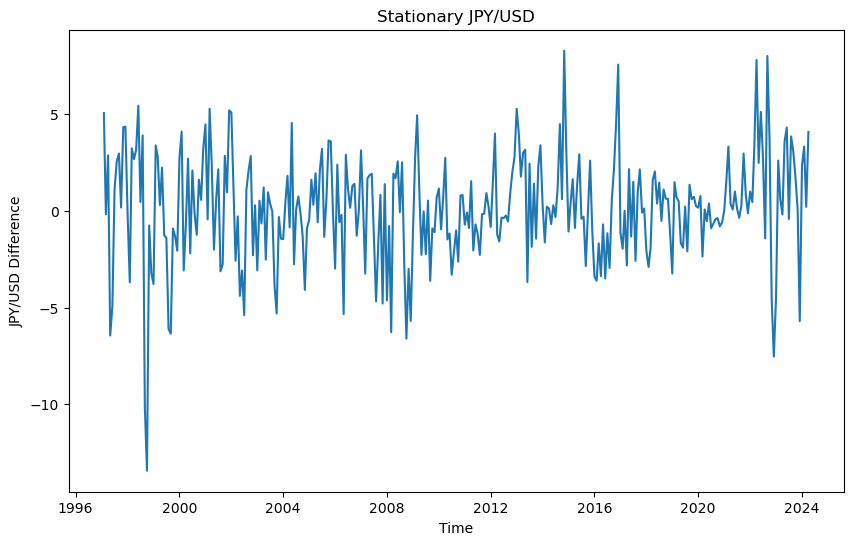

In [14]:
# Plot the stationary data to better visualize it.
plt.figure(figsize=(10, 6))
plt.plot(df_stationary)
plt.title('Stationary JPY/USD')
plt.xlabel('Time')
plt.ylabel('JPY/USD Difference')
plt.show()

# Explanation of negative changes after differencing.
# Negative changes after differencing are due to the fluctuations both positively and negatively over time.
# Differencing calculates the change from one observation to the next, which can result in a negative value.

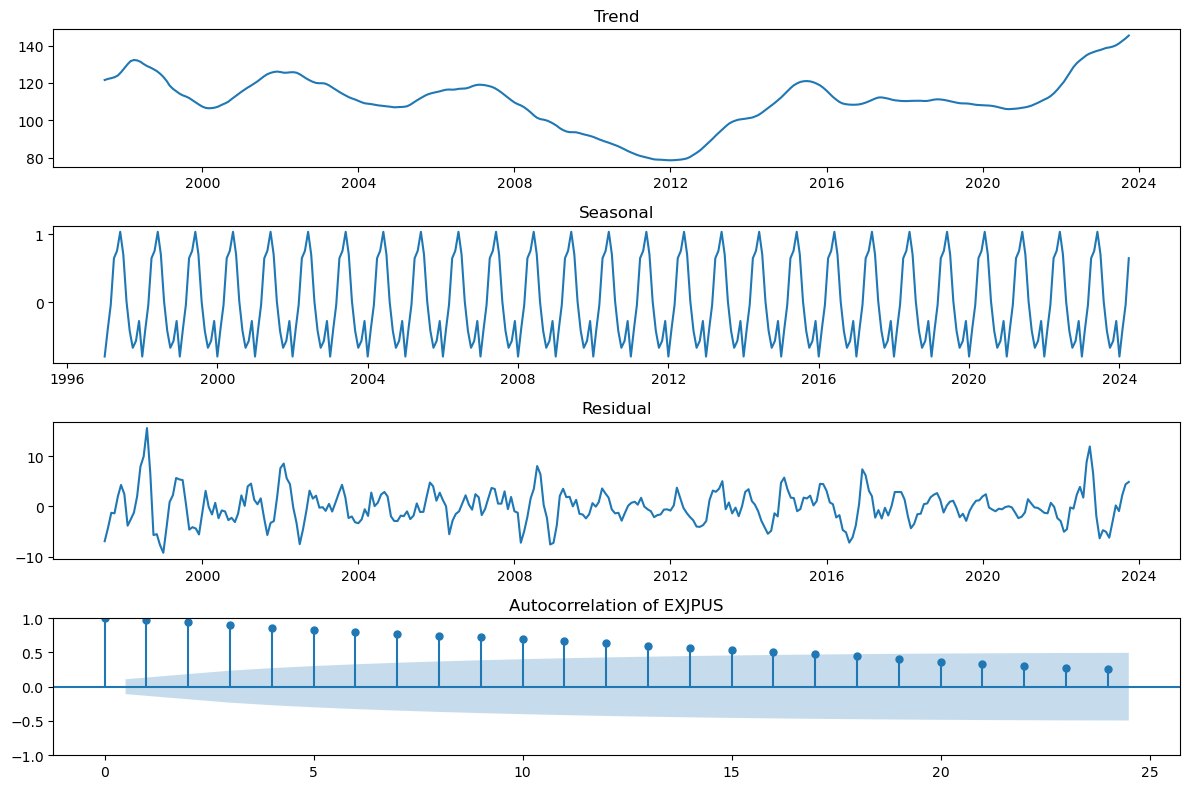

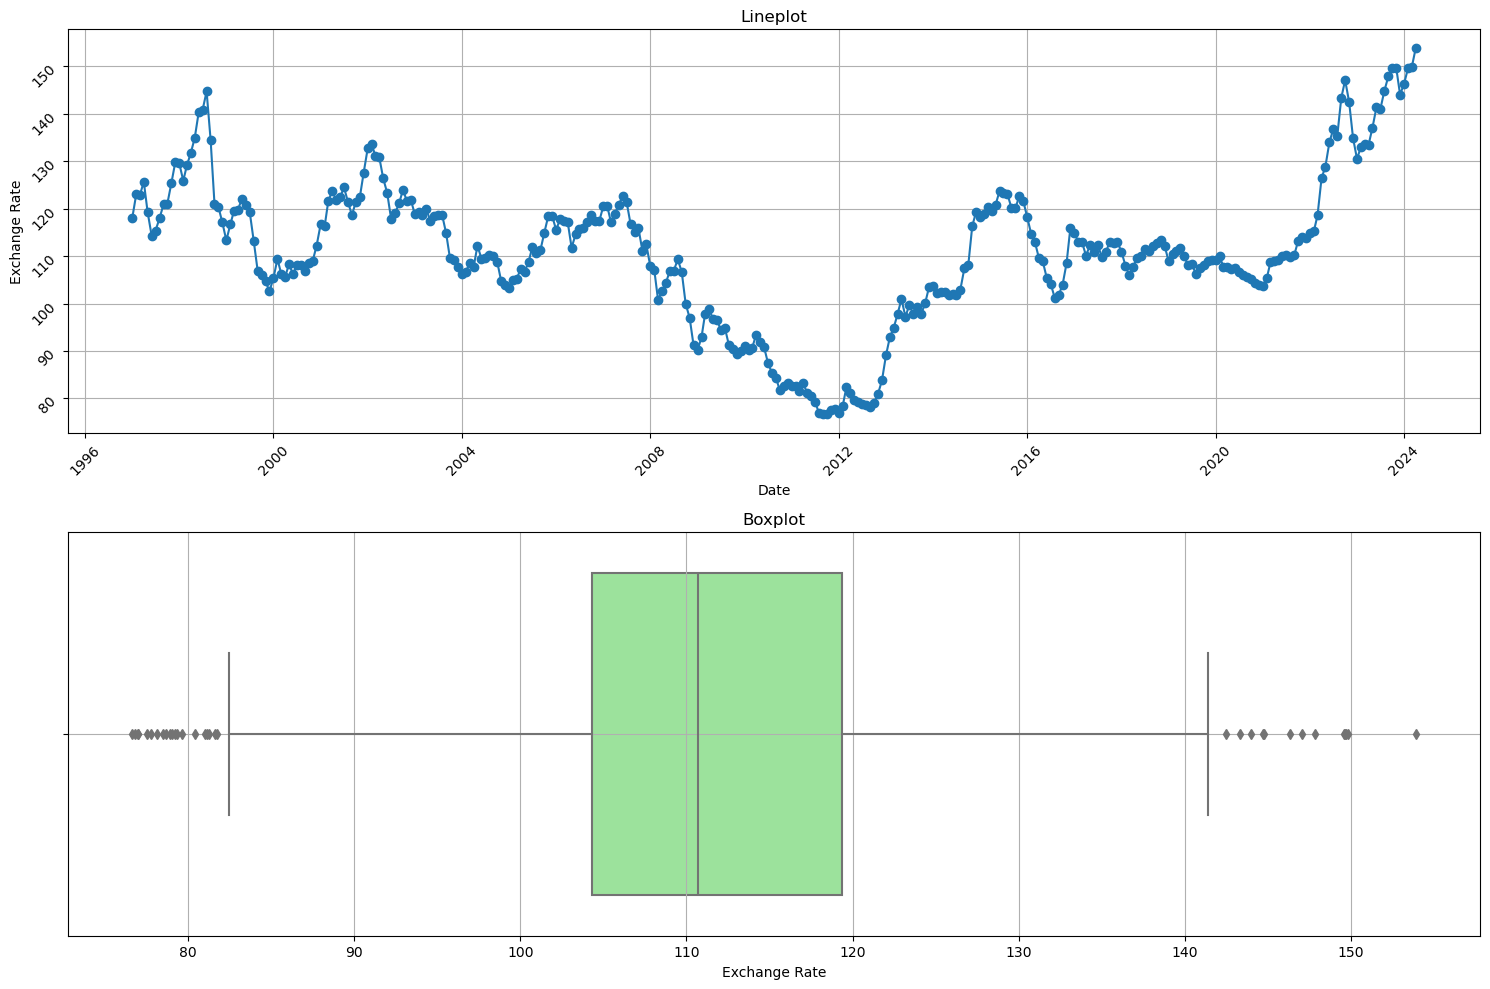

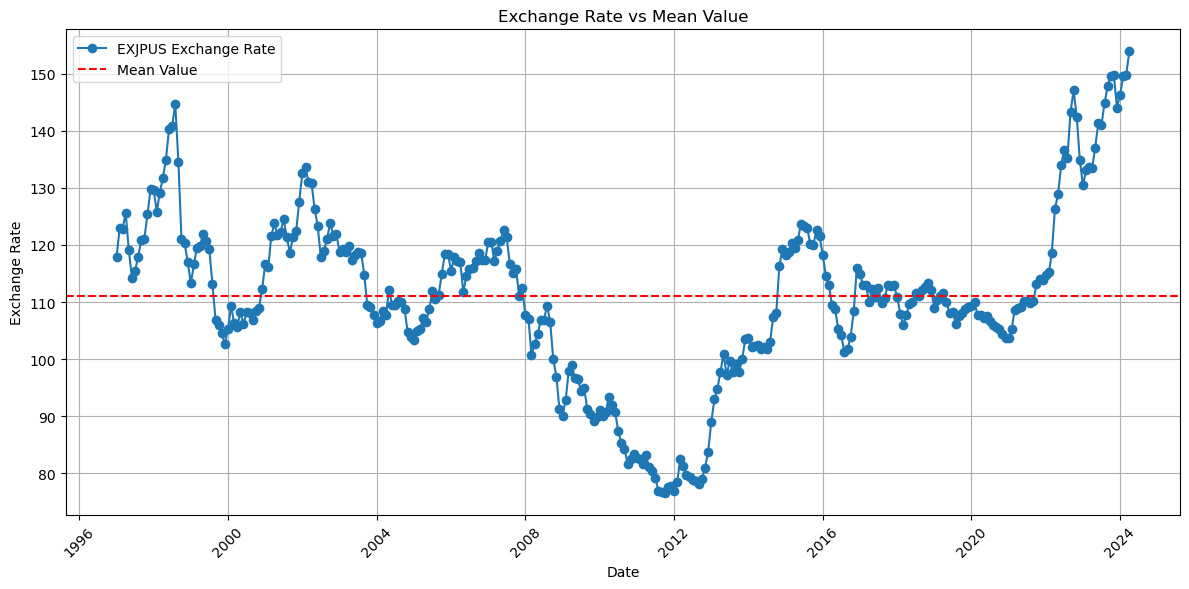

In [18]:
# Decompose the time series
decomposition = seasonal_decompose(df['EXJPUS'], model='additive')
df['Trend'] = decomposition.trend
df['Seasonal'] = decomposition.seasonal
df['Residual'] = decomposition.resid

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
axes[0].plot(df.index, df['Trend'])
axes[0].set_title('Trend')
axes[1].plot(df.index, df['Seasonal'])
axes[1].set_title('Seasonal')
axes[2].plot(df.index, df['Residual'])
axes[2].set_title('Residual')
plot_acf(df['EXJPUS'], lags=24, ax=axes[3])
axes[3].set_title('Autocorrelation of EXJPUS')
plt.tight_layout()
plt.show()

# Plot Lineplot, Boxplot, and Mean vs Exchange Rate
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Lineplot
axes[0].plot(df.index, df['EXJPUS'], marker='o')
axes[0].set_title('Lineplot')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Exchange Rate')
axes[0].tick_params(rotation=45)
axes[0].grid(True)

# Boxplot
sns.boxplot(x=df['EXJPUS'], ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot')
axes[1].set_xlabel('Exchange Rate')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Plot Mean vs Exchange Rate
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['EXJPUS'], marker='o', linestyle='-', label='EXJPUS Exchange Rate')
plt.axhline(y=df['EXJPUS'].mean(), color='red', linestyle='--', label='Mean Value')
plt.title('Exchange Rate vs Mean Value')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Prophet Method for prediction
df_proph = df.rename(columns={'EXJPUS': 'y'})
df_proph['ds'] = df_proph.index

In [20]:
# Sorting Data By Date
df_proph = df_proph.sort_index()

# Split the data into training set 
train = df_proph[df_proph['ds'] < '2018-01-01']

In [21]:
# Fitting the Prophet model
model = Prophet()
model.fit(train)

# Create future dataframe for prediction
future = model.make_future_dataframe(periods=6*12, freq='M')  # 6 years monthly predictions
forecast = model.predict(future)

17:24:57 - cmdstanpy - INFO - Chain [1] start processing
17:24:57 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Showing the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds        yhat  yhat_lower  yhat_upper
319 2023-07-31  152.680884  137.633681  166.330464
320 2023-08-31  151.995056  137.278351  165.100943
321 2023-09-30  154.280904  139.861383  168.120187
322 2023-10-31  158.744149  145.069072  173.115812
323 2023-11-30  157.542431  142.370841  172.485609


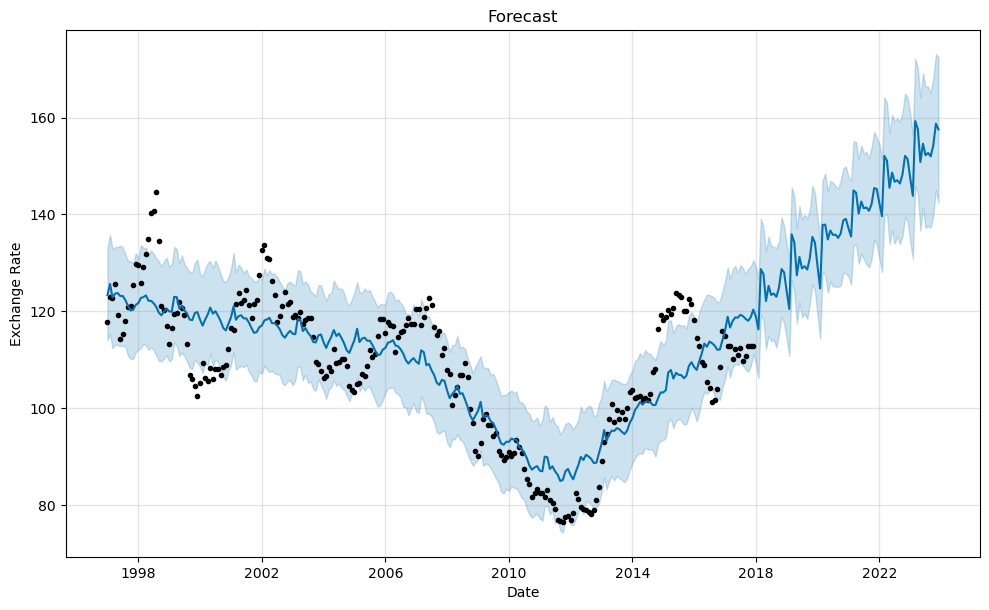

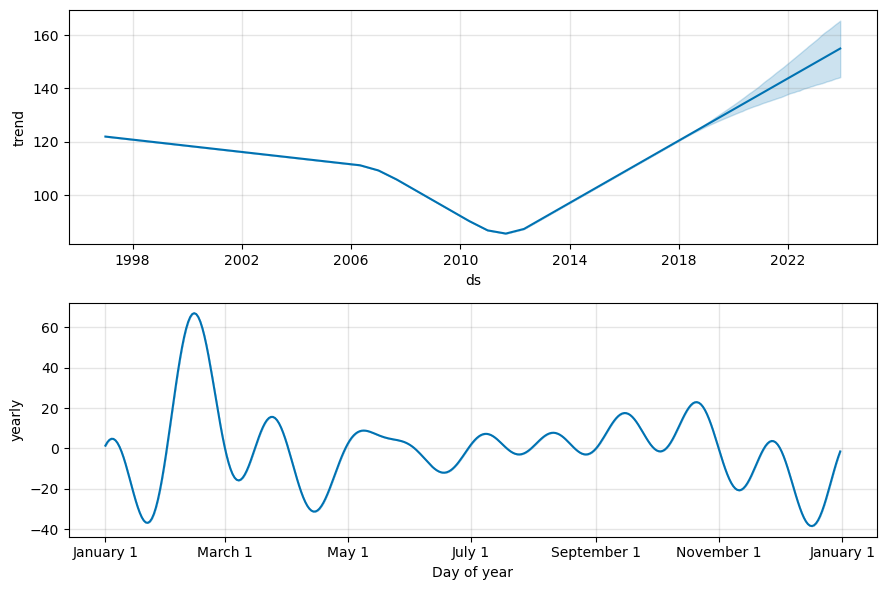

In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ploting the forecast
fig = model.plot(forecast)
plt.title('Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

# Plot components
fig2 = model.plot_components(forecast)
plt.show()

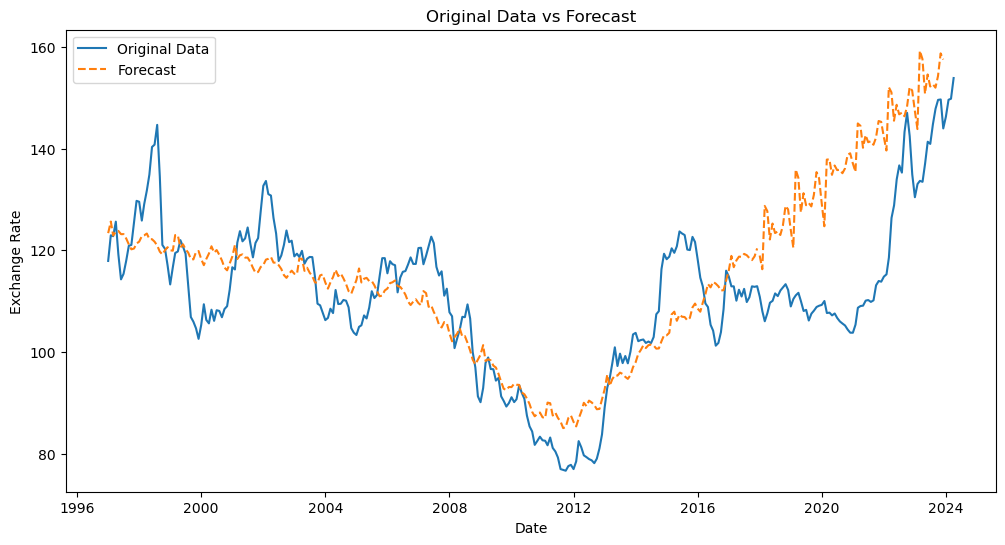

In [24]:
# Extracting relevant columns from the forecast
forecast_df = forecast[['ds', 'yhat']]

# Merging original data with forecasted data
comparison_df = pd.merge(df_proph, forecast_df, on='ds', how='outer')

# Plotting the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['ds'], comparison_df['y'], label='Original Data')
plt.plot(comparison_df['ds'], comparison_df['yhat'], label='Forecast', linestyle='dashed')
plt.title('Original Data vs Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

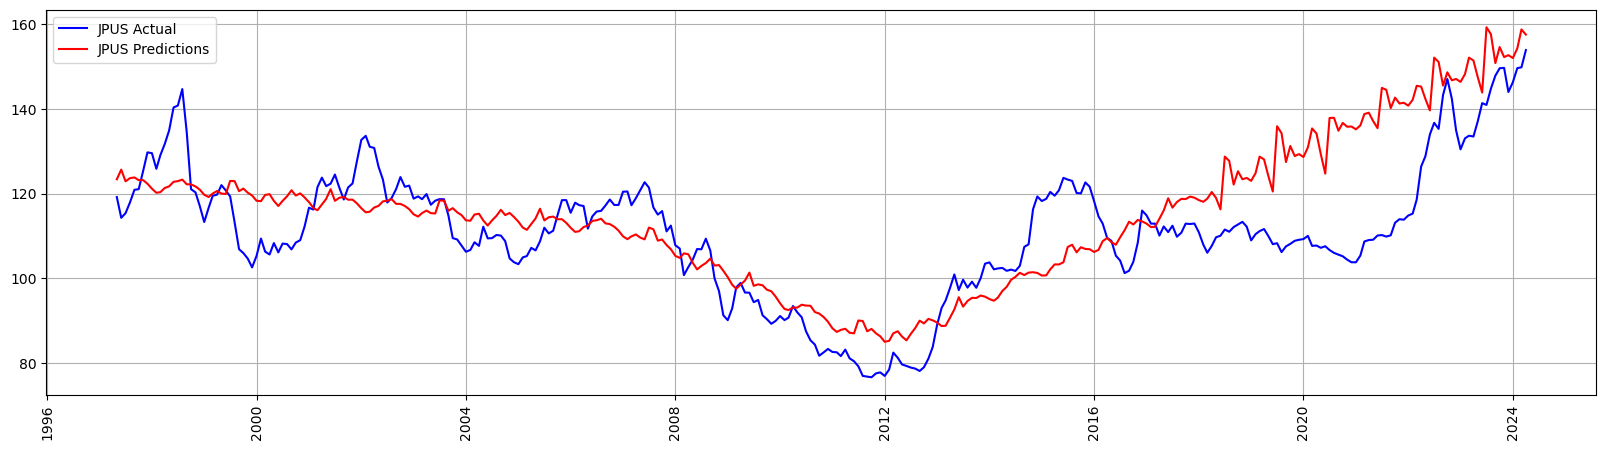

Test RMSE: 12.18488


In [25]:
actuals = df_proph['y']
predictions = forecast['yhat']

# Aligning lengths
if len(actuals) > len(predictions):
    actuals = actuals[-len(predictions):]
else:
    predictions = predictions[-len(actuals):]

# Now both should have the same length
assert len(actuals) == len(predictions), "Lengths of actuals and predictions do not match."

# Plotting the actuals and predictions
plt.figure(figsize=(20, 5))
plt.plot(actuals.index, actuals, color='blue', label='JPUS Actual')
plt.plot(actuals.index, predictions, color='red', label='JPUS Predictions')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Calculating RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print('Test RMSE: %.5f' % rmse)

In [26]:
# Split the data into train and test sets
train = df_stationary[df_stationary.index.year < 2018]
test = df_stationary[df_stationary.index.year >= 2018]
len(train), len(test)

(251, 76)

In [27]:
print("Next, we'll try to predict JPY/USD using the ARIMA model")

Next, we'll try to predict JPY/USD using the ARIMA model


In [28]:
df = df['EXJPUS']

In [29]:
# Split the data into train and test sets
train = df[df.index.year < 2018]
test = df[df.index.year >= 2018]
len(train), len(test)

(252, 76)

In [30]:
# Filter out warnings to improve the clarity of the output
warnings.filterwarnings("ignore")

# Ensure the df is a pandas Series with a DateTimeIndex
df.index = pd.to_datetime(df.index)
df = df.asfreq('MS')  # Resample to start of each month

# Fit a 'base' ARIMA model
model = ARIMA(train, order=(1, 1, 1))  # Base model with AR(1) and MA(1) components
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 EXJPUS   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -608.280
Date:                Wed, 29 May 2024   AIC                           1222.561
Time:                        17:25:30   BIC                           1233.137
Sample:                    01-01-1997   HQIC                          1226.817
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3590      0.212      1.695      0.090      -0.056       0.774
ma.L1         -0.1059      0.213     -0.498      0.619      -0.523       0.311
sigma2         7.4535      0.541     13.775      0.0

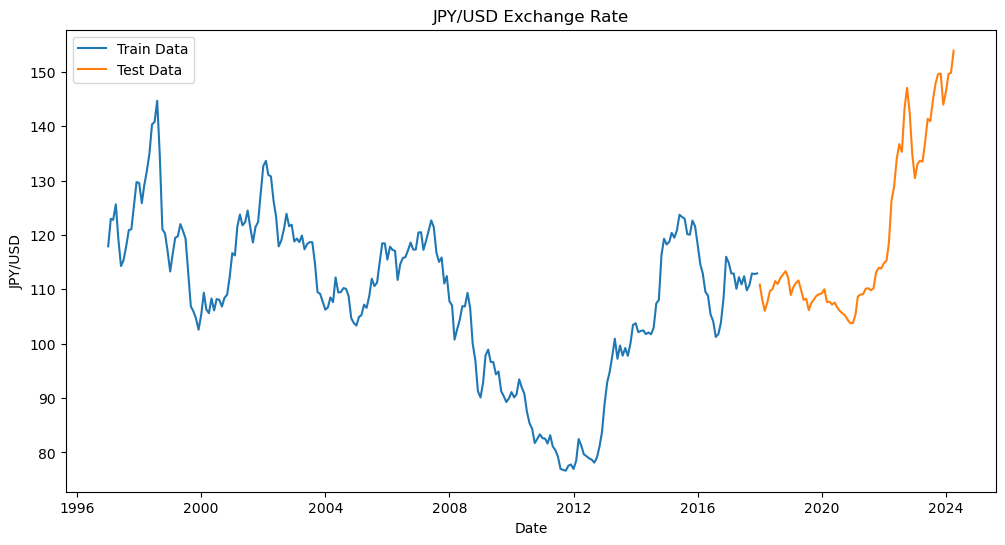

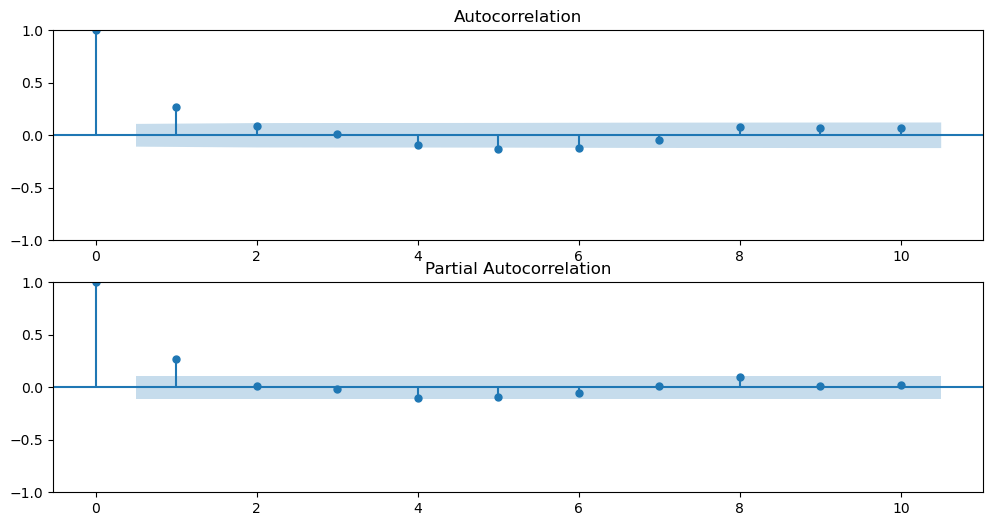

In [31]:
# Given the statistical insignificance (high p-values) of the coefficients,
# we will try different orders for ARIMA (different p, d, q values) or a different model.

# Plot the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data')
plt.xlabel('Date')
plt.ylabel('JPY/USD')
plt.title('JPY/USD Exchange Rate')
plt.legend()
plt.show()

# Check for stationarity with ACF and PACF plots
# Determine the number of lags to show based on the sample size
lags = min(10, len(train) // 2 - 1)

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df_stationary, lags=lags, ax=plt.gca())
plt.subplot(212)
plot_pacf(df_stationary, lags=lags, ax=plt.gca())
plt.show()


New optimal ARIMA(0, 0, 0) - AIC:2062.98567500652
New optimal ARIMA(0, 0, 1) - AIC:1773.9967399179131
New optimal ARIMA(0, 0, 2) - AIC:1573.400508041407
New optimal ARIMA(0, 1, 0) - AIC:1236.2275787625983
New optimal ARIMA(0, 1, 1) - AIC:1223.018718718173
New optimal ARIMA(0, 1, 2) - AIC:1222.6769011664383
New optimal ARIMA(1, 1, 0) - AIC:1220.8420448521472
New optimal ARIMA(2, 1, 2) - AIC:1214.0695135143712
Best params: (2, 1, 2), min_aic: 1214.0695135143712
                               SARIMAX Results                                
Dep. Variable:                 EXJPUS   No. Observations:                  252
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -602.035
Date:                Wed, 29 May 2024   AIC                           1214.070
Time:                        17:25:55   BIC                           1231.697
Sample:                    01-01-1997   HQIC                          1221.163
                         - 12-01-2017                         

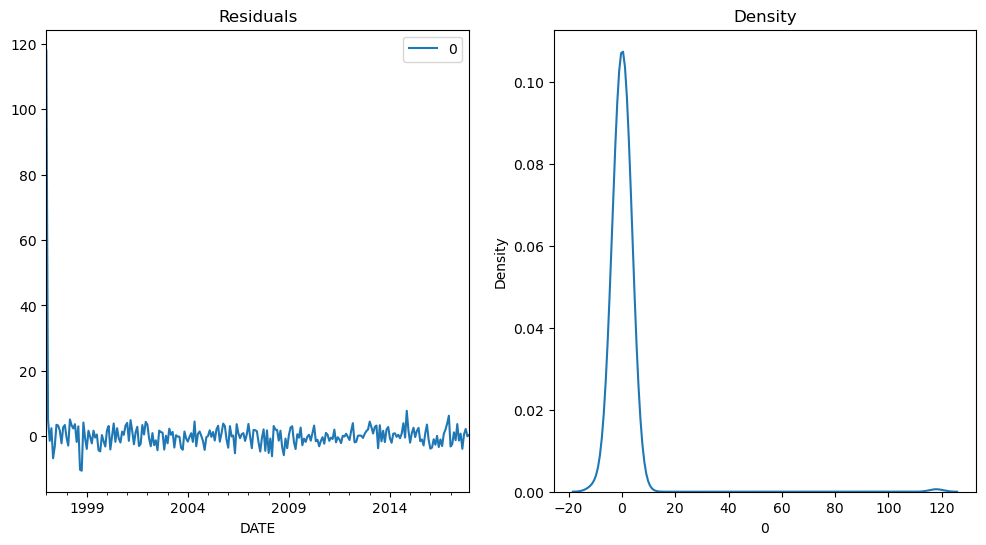

In [32]:
# Define the parameter ranges for ARIMA (p, d, q) model
p = [0, 1, 2, 4, 6]
d = range(0, 3)
q = range(0, 3)

# Initialise variables to store the optimal parameters and minimum AIC
optimal_params = None
min_aic = float('inf')

# Generate all possible combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Perform a grid search
for param in pdq:
    try:
        model = ARIMA(train, order=param)
        results = model.fit()
        
        if results.aic < min_aic:
            optimal_params = param
            min_aic = results.aic
            print(f'New optimal ARIMA{param} - AIC:{results.aic}')
    except Exception as e:
        print(f'Error with parameters {param}: {e}')
        continue

print(f'Best params: {optimal_params}, min_aic: {min_aic}')

# Fit the model with the optimal parameters on the training data
model = ARIMA(train, order=optimal_params)
results = model.fit()

# Print the summary of the fitted model
print(results.summary())

# Plot the residuals of the model (should be near zero mean and uniform variance)
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
residuals.plot(title="Residuals", ax=ax[0])
sns.kdeplot(residuals.iloc[:, 0], ax=ax[1])  # Accessing the first column
ax[1].set_title('Density')
plt.show()


In [33]:
print("In this manual-plotting method, the p-value for the Ljung-Box test is 0.72, indicating no significant autocorrelation.\n"
      "However, the p-values for Jarque-Bera and Heteroskedasticity tests are both 0, suggesting that the residuals may not follow\n" 
      "a normal distribution.")

In this manual-plotting method, the p-value for the Ljung-Box test is 0.72, indicating no significant autocorrelation.
However, the p-values for Jarque-Bera and Heteroskedasticity tests are both 0, suggesting that the residuals may not follow
a normal distribution.


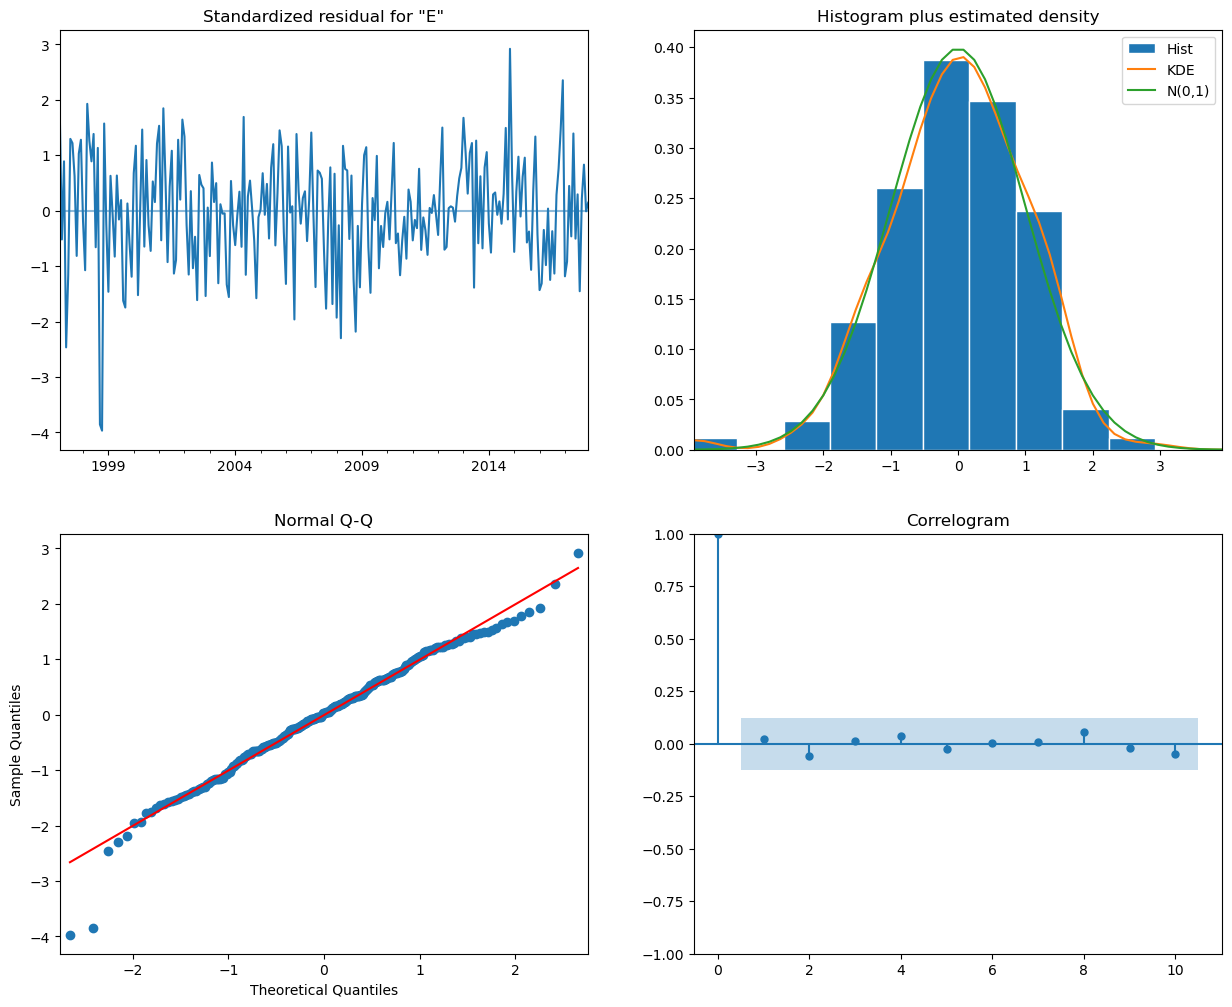

In [34]:
# We try a diagnostic plotting of the residuals below
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [35]:
print("Diagnostic plot of residuals:\n"
      " - Standardized Residuals: The residual errors oscillate around a mean of zero with uniform variation.\n"
      " - Histogram: The density plot suggests a normal distribution of residuals.\n"
      " - Quantile-Quantile Plot: Most dots align closely with the red line, indicating approximate normality.\n"
      " - Correlogram: Autocorrelation Function (ACF) plot shows no significant autocorrelation.\n"
      "Overall, the diagnostic plots support the adequacy of the model.")


Diagnostic plot of residuals:
 - Standardized Residuals: The residual errors oscillate around a mean of zero with uniform variation.
 - Histogram: The density plot suggests a normal distribution of residuals.
 - Quantile-Quantile Plot: Most dots align closely with the red line, indicating approximate normality.
 - Correlogram: Autocorrelation Function (ACF) plot shows no significant autocorrelation.
Overall, the diagnostic plots support the adequacy of the model.


In [36]:
# Check if the residuals we used in both methods above are consistent
# The same results means consistency; the only difference is the second method uses standardised residuals stats. 
print("Manual Residuals (first 5 values):\n", residuals.head())
print("\nPlot Diagnostics Residuals (first 5 values):\n", results.resid.head())

Manual Residuals (first 5 values):
                      0
DATE                  
1997-01-01  117.912400
1997-02-01    5.049467
1997-03-01   -1.426163
1997-04-01    2.444847
1997-05-01   -6.746561

Plot Diagnostics Residuals (first 5 values):
 DATE
1997-01-01    117.912400
1997-02-01      5.049467
1997-03-01     -1.426163
1997-04-01      2.444847
1997-05-01     -6.746561
dtype: float64


In [37]:
print("The same results means consistency so the only difference is that the second method uses standardised residuals stats. ")

The same results means consistency so the only difference is that the second method uses standardised residuals stats. 


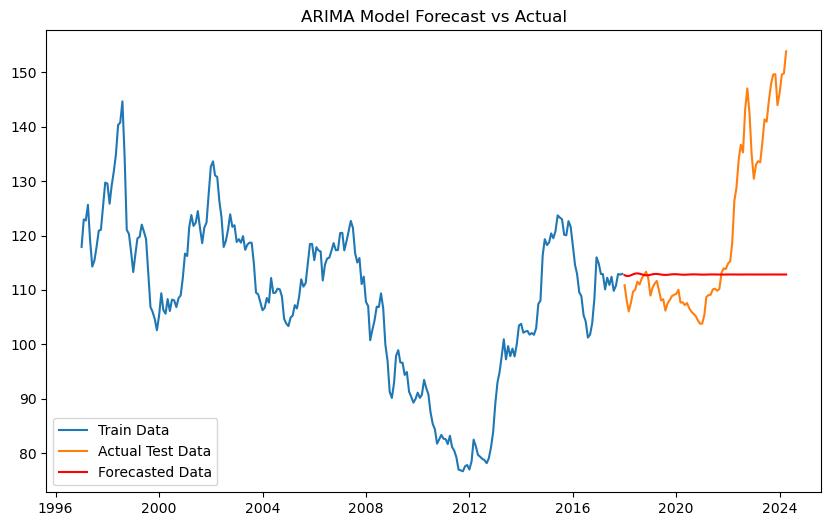

In [38]:
# Generate forecasts for the test period
start = len(train)
end = len(train) + len(test) - 1
forecast = results.predict(start=start, end=end, typ='levels')

# Plot the forecasts using ARIMA against the actual values
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='Forecasted Data', color='red')
plt.legend()
plt.title('ARIMA Model Forecast vs Actual')
plt.show()


In [39]:
# Evaluate the forecast accuracy using MAE, RMSE, MAPE, correlation and Min-max error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs(forecast - test) / np.abs(test)) * 100

# Calculate correlation coefficient
correlation = np.corrcoef(test, forecast)[0, 1]

# Calculate Min-Max Error
mins = np.amin(np.vstack([test, forecast]), axis=0)
maxs = np.amax(np.vstack([test, forecast]), axis=0)
minmax_error = 1 - np.mean(mins / maxs)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Correlation Coefficient: {correlation}')
print(f'Min-Max Error: {minmax_error}')

Mean Absolute Error (MAE): 11.755569885117197
Root Mean Squared Error (RMSE): 16.8973236389381
Mean Absolute Percentage Error (MAPE): 8.853231196317445
Correlation Coefficient: 0.08371467060857105
Min-Max Error: 0.08742554382191103


In [40]:
print ("The relatively low MAE, RMSE, and MAPE values will predict a good forecast of the model. \n"
       "But the weak correlation coefficient suggests the linear relationship between forecasted and observed values is weak.")

The relatively low MAE, RMSE, and MAPE values will predict a good forecast of the model. 
But the weak correlation coefficient suggests the linear relationship between forecasted and observed values is weak.


In [41]:
# Now we try to predict JPY/USD using SARIMAX model to find optimal parameters
# We iterate through different combinations of SARIMA parameters (p, d, q) and seasonal parameters (P, D, Q, S)
# This is in order to find the combination with min AIC value for the best model fit.

# Define the p, d, and q parameters to take any value between 0 and 1
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# Define the seasonal parameters
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # 12 for yearly seasonality

optimal_params = None
min_aic = float('inf')

# Fit SARIMAX model for each parameter combination
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < min_aic:
                optimal_params = (param, param_seasonal)
                min_aic = results.aic

            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            print(f"An error occurred for SARIMA{param}x{param_seasonal}: {e}")
            
print(f'Best params: {optimal_params}, min_aic: {min_aic}')

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:3071.1925371048947
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:2651.4054072606177
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1845.072461764621
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1743.0454650270294
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1852.6688992265185
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1846.554171649448
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1751.978993788823
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1735.0181613573072
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:2726.8833702341954
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2325.3396535700767
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1587.0347185915061
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1497.5140930182047
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1600.9327056853099
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1590.5370522372978
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1510.987759654101
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:1493.7490202441497
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1229.1130292998641
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1164.7498183403093
SARIMA(0, 1, 0

                                     SARIMAX Results                                      
Dep. Variable:                             EXJPUS   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -543.783
Date:                            Wed, 29 May 2024   AIC                           1095.566
Time:                                    17:27:01   BIC                           1109.230
Sample:                                01-01-1997   HQIC                          1101.081
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4397      0.246      1.784      0.074      -0.043       0.923
ma.L1         -0.2549      0.276   

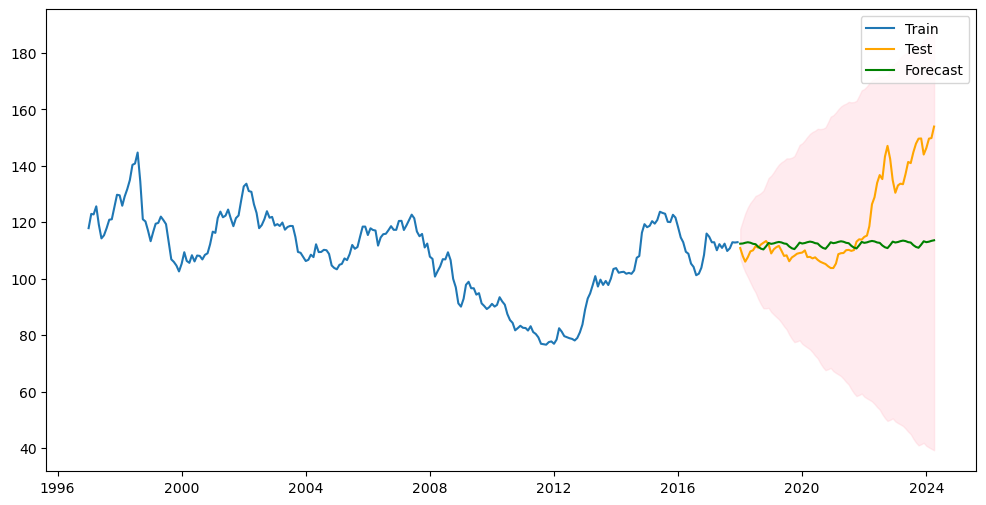

In [42]:
# Define the best SARIMA model and forecast the test set
def fit_sarima_model(train, test, optimal_params):
    model = sm.tsa.statespace.SARIMAX(train,
                                       order=optimal_params[0],
                                       seasonal_order=optimal_params[1],
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
    results = model.fit(disp=False)
    
    # Forecast the test set
    forecast = results.get_forecast(steps=len(test))
    forecasted_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    
    return results, forecasted_values, confidence_intervals

# Print forecast results
def print_forecast_results(forecasted_values, confidence_intervals):
    print(f'Forecasted values: {forecasted_values}')
    print(f'Confidence intervals: {confidence_intervals}')

# Plot the results
def plot_results(train, test, forecasted_values, confidence_intervals):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test', color='orange')
    plt.plot(forecasted_values, label='Forecast', color='green')
    plt.fill_between(forecasted_values.index, 
                     confidence_intervals.iloc[:, 0], 
                     confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
    plt.legend()
    plt.show()

# Fit the best model on the train set using optimal parameters
model_sarima, forecasted_values, confidence_intervals = fit_sarima_model(train, test, optimal_params)
print(model_sarima.summary())
print_forecast_results(forecasted_values, confidence_intervals)
plot_results(train, test, forecasted_values, confidence_intervals)

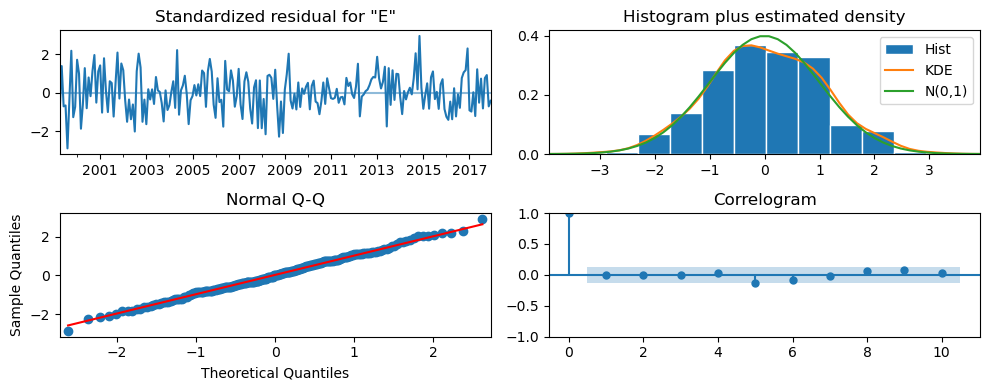

In [43]:
model_sarima.plot_diagnostics(figsize=(10, 4))
plt.tight_layout()

In [44]:
print("Diagnostic plot of residuals:\n"
      " - Standardized Residuals: The residual errors oscillate around a mean of zero with uniform variation.\n"
      " - Histogram: The density plot suggests a normal distribution of residuals.\n"
      " - Quantile-Quantile Plot: Most dots align closely with the red line, indicating approximate normality.\n"
      " - Correlogram: Autocorrelation Function (ACF) plot shows no significant autocorrelation.\n"
      "Overall, the diagnostic plots support the adequacy of the model.")

Diagnostic plot of residuals:
 - Standardized Residuals: The residual errors oscillate around a mean of zero with uniform variation.
 - Histogram: The density plot suggests a normal distribution of residuals.
 - Quantile-Quantile Plot: Most dots align closely with the red line, indicating approximate normality.
 - Correlogram: Autocorrelation Function (ACF) plot shows no significant autocorrelation.
Overall, the diagnostic plots support the adequacy of the model.


In [45]:
# Calculate and print forecast accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100  # Mean Absolute Percentage Error
    me = np.mean(forecast - actual)  # Mean Error
    mae = mean_absolute_error(actual, forecast)  # Mean Absolute Error
    mpe = np.mean((forecast - actual) / actual) * 100  # Mean Percentage Error
    rmse = np.sqrt(mean_squared_error(actual, forecast))  # Root Mean Squared Error
    
    print('SARIMAX Forecast accuracy metrics:')
    print(f'- MAPE (%): {mape:.2f} (Mean Absolute Percentage Error)')
    print(f'- ME: {me:.2f} (Mean Error)')
    print(f'- MAE: {mae:.2f} (Mean Absolute Error)')
    print(f'- MPE (%): {mpe:.2f} (Mean Percentage Error)')
    print(f'- RMSE: {rmse:.2f} (Root Mean Squared Error)')
    
# Calculate and print forecast accuracy metrics
# Lower values of MAPE, MAE, and RMSE indicate better forecast accuracy.
forecast_accuracy(forecasted_values, test)

SARIMAX Forecast accuracy metrics:
- MAPE (%): 8.72 (Mean Absolute Percentage Error)
- ME: -7.32 (Mean Error)
- MAE: 11.63 (Mean Absolute Error)
- MPE (%): -4.69 (Mean Percentage Error)
- RMSE: 17.01 (Root Mean Squared Error)


In [46]:
print("Now, we'll try MLP Prediction Model")

Now, we'll try MLP Prediction Model


In [49]:
# We prepare the packages for the MLP Prediction Model
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras import layers, backend as K
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import time
from math import sqrt

# If you still need the sigmoid function
sigmoid = keras.activations.sigmoid

In [50]:
df.head()

DATE
1997-01-01    117.9124
1997-02-01    122.9621
1997-03-01    122.7738
1997-04-01    125.6377
1997-05-01    119.1924
Freq: MS, Name: EXJPUS, dtype: float64

In [51]:
df_stationary.head()

,EXJPUS
DATE,
1997-02-01,5.0497
1997-03-01,-0.1883
1997-04-01,2.8639
1997-05-01,-6.4453
1997-06-01,-4.9067


In [52]:
df_stationary.columns

Index(['EXJPUS'], dtype='object')

In [55]:
# Ensure df is a DataFrame
if isinstance(df, pd.Series):
    df = df.to_frame()

# Check if 'EXJPUS' is in the DataFrame and move it to the end
if 'EXJPUS' in df.columns:
    # Move the 'EXJPUS' column to the end of the DataFrame
    df = df[[col for col in df.columns if col != 'EXJPUS'] + ['EXJPUS']]
else:
    print("Column 'EXJPUS' not found in the DataFrame")

# Display the last few rows of the DataFrame
df.tail()


,EXJPUS
DATE,
2023-12-01,143.9815
2024-01-01,146.2943
2024-02-01,149.6150
2024-03-01,149.8186
2024-04-01,153.8900


In [56]:
# We scale the multivariate data for the purpose of network approximation
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_stationary)
X = pd.DataFrame(df_scaled, columns=df_stationary.columns)
X.tail()

,EXJPUS
322,0.356343
323,0.725398
324,0.771835
325,0.628222
326,0.806422


In [57]:
def CreateLaggedSequence(data, lag):
    # We start making two different lists for Predictor Sequences and Response Variables
    PredictorSequences, ResponseVariables = list(), list()
    for i in range(len(data)):
    # Marking the range of the sequence
        end_i = i + lag
    # Verifying the time when the data ends
        if end_i+1 > len(data):
    # We break-stop the sequence creation
            break
    # Obtaining the predictors and responses
        PredictorSequence = data[i:end_i]
        ResponseVariable = data[end_i, -1]
    # Appending reponses and predictors to the lists
        PredictorSequences.append(PredictorSequence)
        ResponseVariables.append(ResponseVariable)
    # Print(end_i)
    return np.array(PredictorSequences), np.array(ResponseVariables)

In [58]:
# We define input parameters
NumberOfFeatures = len(df_stationary.columns)
lag = 5
# We create the lagged values for the series (5 lags)
np_X = np.array(X)
X, y = CreateLaggedSequence(np_X, lag)
# Reshaping them for the process
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X.shape, y.shape

((322, 5), (322,))

In [59]:
# We split the train and test sets (last 50 observation are spared for the test)
x_train, x_test = X[:-50], X[-50:]
y_train, y_test = y[:-50], y[-50:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((272, 5), (50, 5), (272,), (50,))

In [60]:
# Checking the packages for the predictions
import numpy as np
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import sigmoid

In [61]:
# We define new activation function
def swish(x, beta=1):
    return x * sigmoid(beta * x)

get_custom_objects().update({'swish': Activation(swish)})

In [62]:
# We import the time module for the prediction
import time  
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, backend
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Defining the swish activation function
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.activations import sigmoid

def swish(x, beta=1):
    return x * sigmoid(beta * x)

get_custom_objects().update({'swish': Activation(swish)})

x_train = np.random.rand(1000, 20)
y_train = np.random.rand(1000, 1)
x_test = np.random.rand(200, 20)
y_test = np.random.rand(200, 1)

# We create the starting point of the timer
start = time.time()

# Model Design
backend.clear_session()
model = models.Sequential()

model.add(layers.Dense(3*2**10, activation='swish', kernel_initializer='he_uniform', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(3*2**8, activation='swish', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(layers.Dense(3*2**6, activation='swish', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(layers.Dense(3*2**4, activation='swish', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(layers.Dense(3*2**2, activation='swish', kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(layers.Dense(3*2**0, activation=tf.keras.backend.sin, kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

model.add(layers.Dense(1, activation='swish'))

# we assemble the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.00007), loss='mse', metrics=['mae'])

# Obtaining model summary
model.summary()

# Model fitting
history = model.fit(x_train, y_train, 
                    epochs=2**10, 
                    batch_size=3892, 
                    validation_split=0.20, 
                    verbose=1, 
                    callbacks=[EarlyStopping(monitor='val_mae', patience=2**6, restore_best_weights=True)])

# Evaluating the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

# End the timer and printing the total time passed
end = time.time()
print("Total time:", end-start, "seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3072)           │        64,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 768)            │     2,360,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 48)             │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,582,119 (9.85 MB)

 Trainable params: 2,582,119 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3035 - mae: 0.4574 - val_loss: 0.2038 - val_mae: 0.3823
Epoch 2/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.2697 - mae: 0.4226 - val_loss: 0.1795 - val_mae: 0.3557
Epoch 3/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.2534 - mae: 0.4147 - val_loss: 0.1732 - val_mae: 0.3484
Epoch 4/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.2349 - mae: 0.3969 - val_loss: 0.1636 - val_mae: 0.3376
Epoch 5/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.2288 - mae: 0.3925 - val_loss: 0.1486 - val_mae: 0.3209
Epoch 6/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.2250 - mae: 0.3822 - val_loss: 0.1479 - val_mae: 0.3202
Epoch 7/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.2351 - mae: 0.3903 - val_loss: 0.1592 - val_mae: 0.3331
Epoch 8/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.2252 - mae: 0.3884 - val_loss: 0.1742 - val_mae: 0.3504
Epoch 9/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss:

In [63]:
# We predict the model on the test set (scaled)
yhat_scaled = model.predict(x_test, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [64]:
np.random.seed(0)
df = pd.DataFrame({
    'feature1': np.random.rand(328),  # Assuming 328 rows for the example
    'feature2': np.random.rand(328)
})
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

# Simulating predictions
yhat_scaled = np.random.rand(327, df.shape[1])

# Checking the shapes
print(f"df_scaled shape: {df_scaled.shape}")
print(f"yhat_scaled shape: {yhat_scaled.shape}")

# Ensuring the indices align correctly for inserting predictions
if len(yhat_scaled) != len(df_scaled.iloc[-len(yhat_scaled):]):
    raise ValueError("The length of yhat_scaled does not match the portion of df_scaled it should replace.")

# Inserting the scaled predictions into the scaled DataFrame
df_scaled.iloc[-len(yhat_scaled):] = yhat_scaled

# Inverting the scaled data (with the predictions) back to real values
df_inverted = scaler.inverse_transform(df_scaled)

# Converting the data to DataFrame
df_invertedDF = pd.DataFrame(df_inverted, columns=df.columns, index=df.index)

# We display the first few rows of the inverted DataFrame
print(df_invertedDF.head())

df_scaled shape: (328, 2)
yhat_scaled shape: (327, 2)
   feature1  feature2
0  0.548814  0.283519
1  0.472564  0.118140
2  0.459081  0.979309
3  0.425924  0.856892
4  0.121325  0.273026


In [65]:
df_scaled[-len(yhat_scaled):] = yhat_scaled
# inverting the scaled data (with the predictions) back to real values
df_inverted = scaler.inverse_transform(df_scaled)
# converting the data to dataframe
df_invertedDF = pd.DataFrame(df_inverted, columns=df.columns, index=df.index)

In [66]:
# We convert the predictions series
predictions = df_invertedDF.iloc[-len(yhat_scaled):, -1]
# We extract the actual values
actuals = df_stationary[-50:]

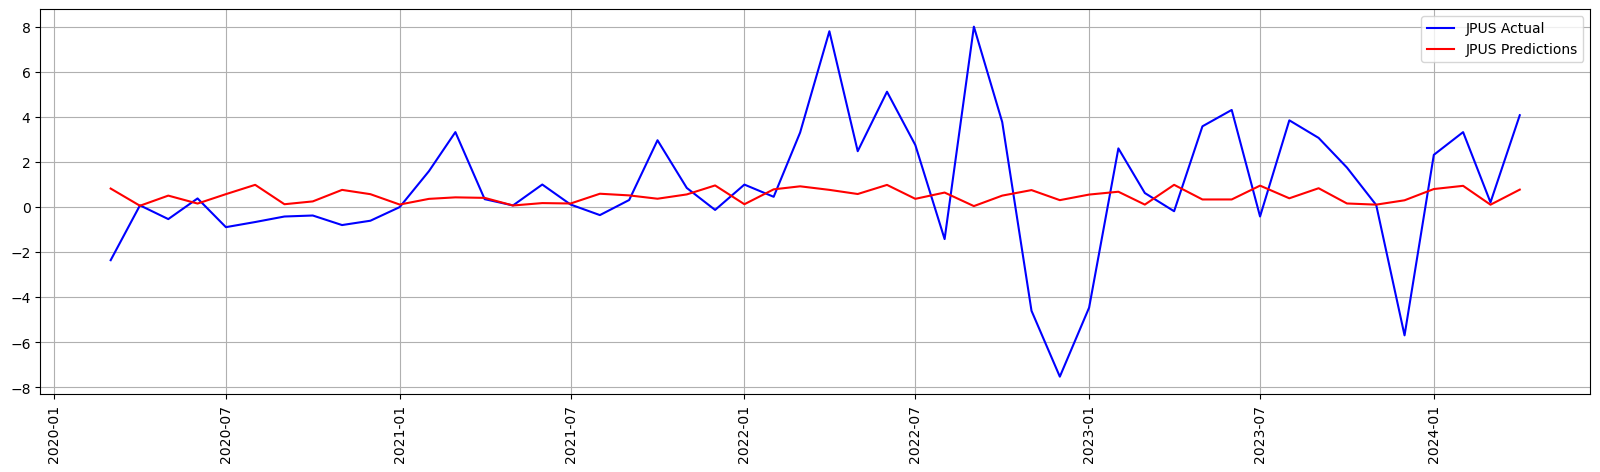

Test RMSE: 2.91210


In [67]:
# Forecast evaluation and plotting
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
if len(actuals) != len(predictions):
# Slicing it to match actuals length
    predictions = predictions[-len(actuals):]

# Now both have the same length
assert len(actuals) == len(predictions), "Lengths of actuals and predictions do not match."

# Plotting the actuals and predictions
plt.figure(figsize=(20, 5))
plt.plot(actuals.index, actuals, color='blue', label='JPUS Actual')
plt.plot(actuals.index, predictions, color='red', label='JPUS Predictions')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Calculating RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print('Test RMSE: %.5f' % rmse)